# Computer Assigment 3 - Classification of Handwritten Digits



## Imports

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

%matplotlib inline

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['image.cmap'] = 'gray'
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

## Read Data

* We will use the `data.xlsx` sheet to read the train and test set respectively. The labels are saved under the `dzip` and `dtest` sheets, for the train and test dataset respectively, while the values are vector of 256 length under the `azip` snf `testzip` sheets respectively.

In [46]:
def read_data(label, values):
    df = pd.read_excel('data.xlsx', sheet_name=label, header=None)
    df = df.append(pd.read_excel('data.xlsx', sheet_name=values, header=None), ignore_index = True)
    return df

In [47]:
train = read_data('dzip', 'azip')
test = read_data('dtest', 'testzip')

As shown below the first row contains the digit's value, while the following 256, contain the values (between -1 and 1) for each of the 256 digit's pixels.

In [48]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,1697,1698,1699,1700,1701,1702,1703,1704,1705,1706
0,6.0,5.000,4.0,7.0,3.0,6.0,3.00,1.0,0.0,1.0,...,8.0,0.000,5.0,1.0,9.0,8.0,9.0,7.0,9.0,8.0
1,-1.0,-1.000,-1.0,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0,...,-1.0,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.000,-1.0,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0,...,-1.0,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.000,-1.0,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0,...,-1.0,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,-0.813,-1.0,-1.0,-1.0,-1.0,-0.83,-1.0,-1.0,-1.0,...,-1.0,-0.567,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [49]:

test.head()

,0,1,2,3,4,5,6,7,8,9,...,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006
0,9.0,6.0,3.000,6.0,6.0,0.0,0.0,0.0,6.0,9.0,...,7.0,5.000,2.00,0.0,4.0,3.0,9.0,4.0,0.0,1.0
1,-1.0,-1.0,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.000,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.000,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.000,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-0.593,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-0.885,-0.98,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


## Plot sample digit

* The `NormalizeImage` function performs a normalization and plots the input digit if chosen.

In [50]:
def NormalizeImage(image, inverse=False, show=False):

    """
    Function that takes a pd.Series as argument and plots the outpout in a 16x16 image. Colors can be inverted using the Inverse argument.
    Input: pd.Series, boolean
    Output: None
    """
    num = image[1:]
    num = (num-min(num)*np.ones(num.shape[0]))
    num = (20/max(num))*num
    if inverse:
        num = num*-1

    if show:
        print("Number:", image[0])
        plt.imshow(num.values.reshape(16, 16))
        plt.show()
    return num.values.reshape(16, 16)

* Let's plot the first column of the train set. This corresponds to the number 6

Number: 6.0


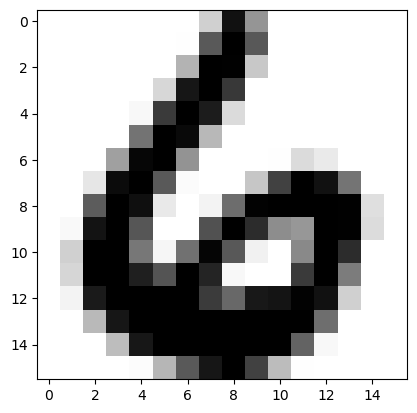

In [51]:
_ = NormalizeImage(train.iloc[:,0], True, True)

## Part 1 - Simple Algorithm

* We will start by implementing a simple algorithm that initially computes the mean of each class (using the corresponding classes from the train set) and classifies the new test numbers using the smallest distance.

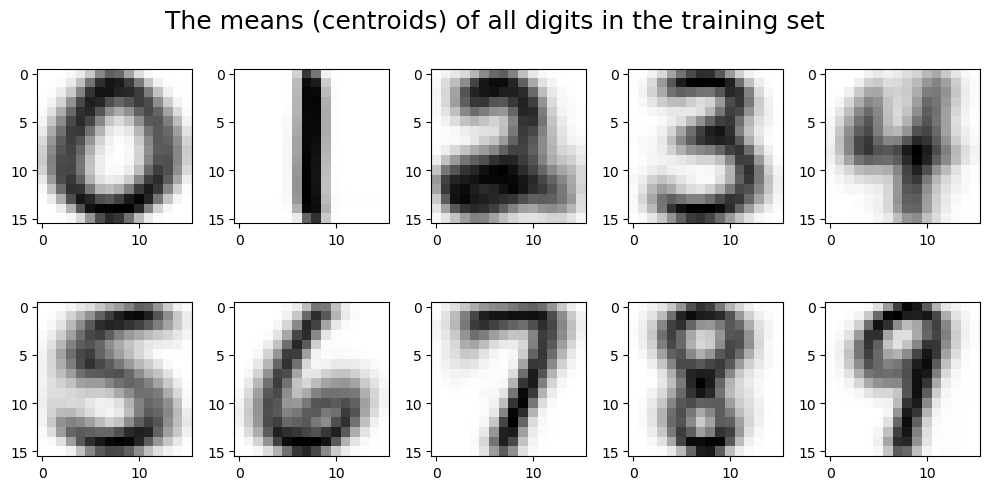

In [52]:
means = np.zeros((256,10))
for i in range(10):
    means[:,i] = train.loc[:, train.loc[0]==i].mean(axis=1)[1:]

fig, ax = plt.subplots(2, 5, figsize=(10,5))

for i, triaxes in enumerate(ax.reshape(-1)):
    triaxes.imshow(means[:,i].reshape(16, 16)*-1)

fig.tight_layout()
fig.suptitle('The means (centroids) of all digits in the training set', fontsize=18, y=1.01)
plt.show()

### Make predictions using the test set.

In [53]:
def calc_dist(means, y):
    """
    Function that calculated the Eucledian Distance between two vectors.
    Input: np.array, pd.Series
    output: int
    """
    y_actual = y[0]
    y = y[1:]
    dist = np.zeros(10)
    for i in range(means.shape[1]):
        dist[i] = np.linalg.norm(means[:,i] - y.values)

    return [1 if int(y_actual) == int(np.argmin(dist)) else 0][0]

In [54]:
sum, sample = 0, []
for col in test:
    pred = calc_dist(means, test[col])
    sum += pred
    if pred == 1 and len(sample) == 0:
        sample.append(col)
print(f"The simple model has an accuracy of: {sum/test.shape[1]*100:.2f}%")


The simple model has an accuracy of: 80.87%


* As expected the results fetched using this simple algorithm are sub-par. In the variable `sample` we saved an example of a missclassified digit:

Actual Value: 9. Predicted value 1.
Number: 9.0


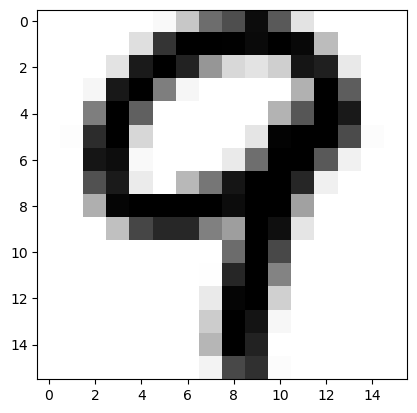

In [55]:
print(f"Actual Value: {int(test[0][0])}. Predicted value {int(calc_dist(means, test[col]))}.")
_ = NormalizeImage(test.iloc[:,0], True, True)

## Part 2 - Classification using SVD Bases

### Calculate SVD using the train set

* Following the apporach of Chanpter 10.2, we will derive the SVD of each digit using the matrix of each digit as shown in Figure 1

<img src="./Plots/Screenshot_1.png" width="500px">\
**Figure 1.** Each digit is represented by a column in the matrix.

The output for the corresponding SVD tables will be saved in the `u`, `s`, `vh` lists for each digit, so that we can later easily itterate through them. 

In [56]:
u, s, vh = [], [], []
for i in range(10):
    u_temp, s_temp, vh_temp = np.linalg.svd(train.loc[:, train.loc[0]==i][1:])
    u.append(u_temp), s.append(s_temp), vh.append(vh_temp)

# Sanity Check
print("Sanity Check. u, s, v shape for each digit:")
for j in range(10):
    print(f"digit: {j}, u: {u[j].shape}, s: {s[j].shape}, v: {vh[j].shape}")

Sanity Check. u, s, v shape for each digit:
digit: 0, u: (256, 256), s: (256,), v: (319, 319)
digit: 1, u: (256, 256), s: (252,), v: (252, 252)
digit: 2, u: (256, 256), s: (202,), v: (202, 202)
digit: 3, u: (256, 256), s: (131,), v: (131, 131)
digit: 4, u: (256, 256), s: (122,), v: (122, 122)
digit: 5, u: (256, 256), s: (88,), v: (88, 88)
digit: 6, u: (256, 256), s: (151,), v: (151, 151)
digit: 7, u: (256, 256), s: (166,), v: (166, 166)
digit: 8, u: (256, 256), s: (144,), v: (144, 144)
digit: 9, u: (256, 256), s: (132,), v: (132, 132)


### Understanding the SVD tables

* From the results it is obvious that the SVD's tables have been salculated correctly. We will proceed with plotting the various matrices for the digit 3 (similar to **Figure 10.5** of Chapter 10).

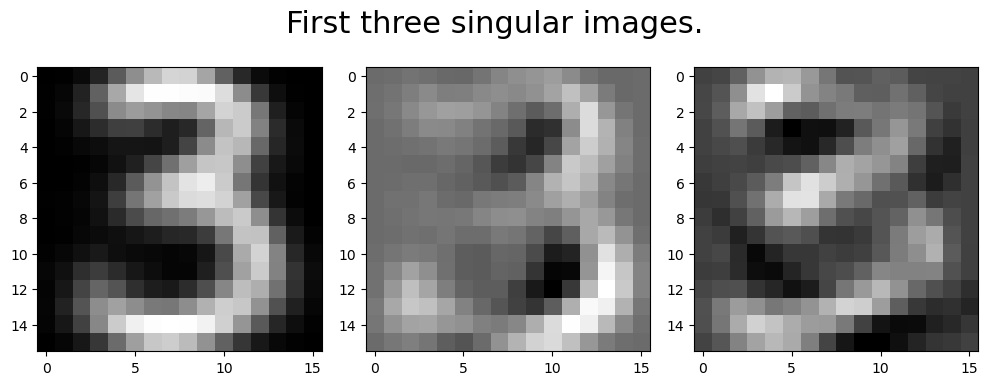

In [57]:
fig, ax = plt.subplots(1, 3, figsize=(10,5))

for i, triaxes in enumerate(ax.reshape(-1)):
    triaxes.imshow(u[3][:,i].reshape(16,16))

fig.tight_layout()
fig.suptitle('First three singular images.', fontsize=22, y=0.9)

plt.show()


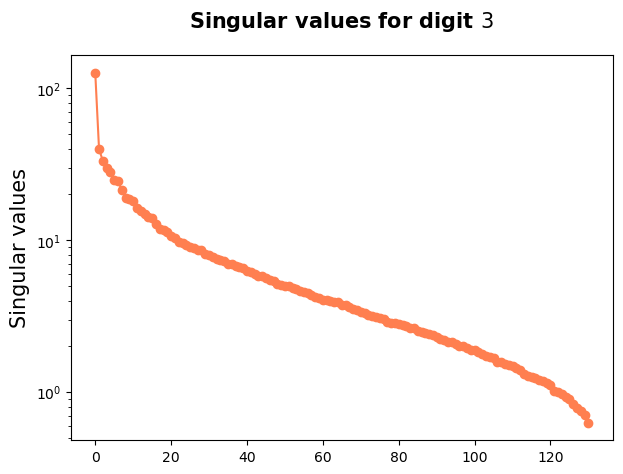

In [58]:
plt.figure(figsize = (7, 5))
plt.plot(s[3], color='coral', marker='o')
plt.title('Singular values for digit $3$',fontsize=15,weight='bold',pad=20)
plt.ylabel('Singular values' ,fontsize=15)
plt.yscale('log')
plt.show()

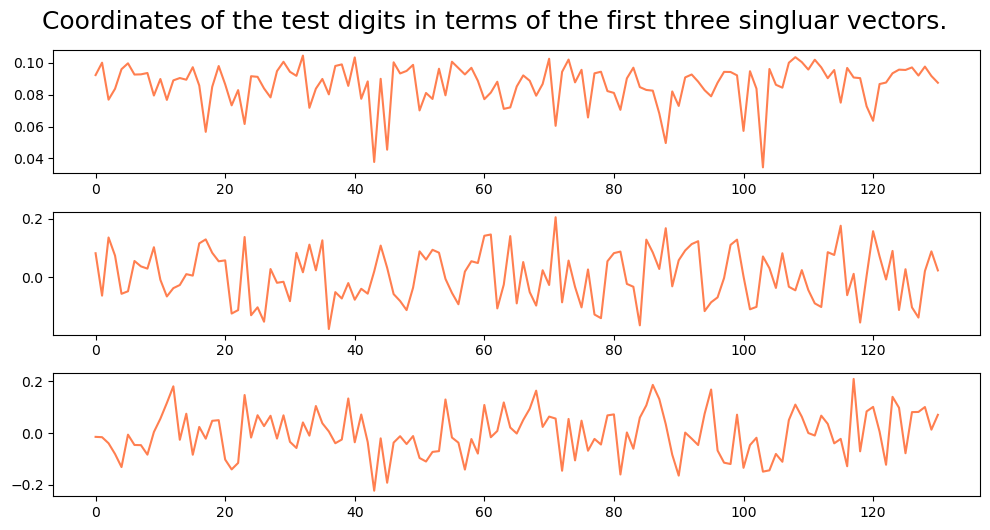

In [59]:
fig, ax = plt.subplots(3, 1, figsize=(10,5))

for i, triaxes in enumerate(ax.reshape(-1)):
    triaxes.plot(vh[3][i], color='coral')

fig.tight_layout()
fig.suptitle('Coordinates of the test digits in terms of the first three singluar vectors.', fontsize=18, y=1.05)

plt.show()


### Relative Residual Norm

The SVD basis classification algorithm will be based on the following assumptions:
1. Each digit (in the training set and the test set) is well characterized by a few of the first singular images of its own kind. The more precise meaning of "few" should be investigated in experiments.
2. An expansion in terms of the first few singular images discriminates well between the different classes of digits.
3. If an unknown digit can be better approximated in one particular basis of singular images, the basis of 3’s say, than in the bases of the other classes, then it is likely that the unknown digit is a 3.

* As we know the solution of the problem is given by $\alpha = U_k^Tz$ and the norm of the residual vector of the least squares problems is:

$$ \Vert (I - U_k U_k^T)z \Vert_2 $$

To demonstrate that the assumptions above are reasonable we will illustrate the ralative residual norm for all train 3's and 7's. The relative residual norm in given by:

$$ \Vert (I - U_k U_k^T)z \Vert_2 / \Vert z \Vert_2$$

In [60]:
def calc_resid(digit, bases):
    """
    Function that calculates and returns the relative residual norm of all bases, given a specific digit.
    The function also takes the number of bases as argument
    Input: pd.Series, itn
    Output: int
    """
    res = []
    # for each base, calculate and append the residual
    for i in range(10):
        u_k = u[i][:,0:bases]
        r = np.linalg.norm( (I-(u_k.dot(u_k.T))).dot(digit) ) / np.linalg.norm(digit)
        res.append(r)
    return res

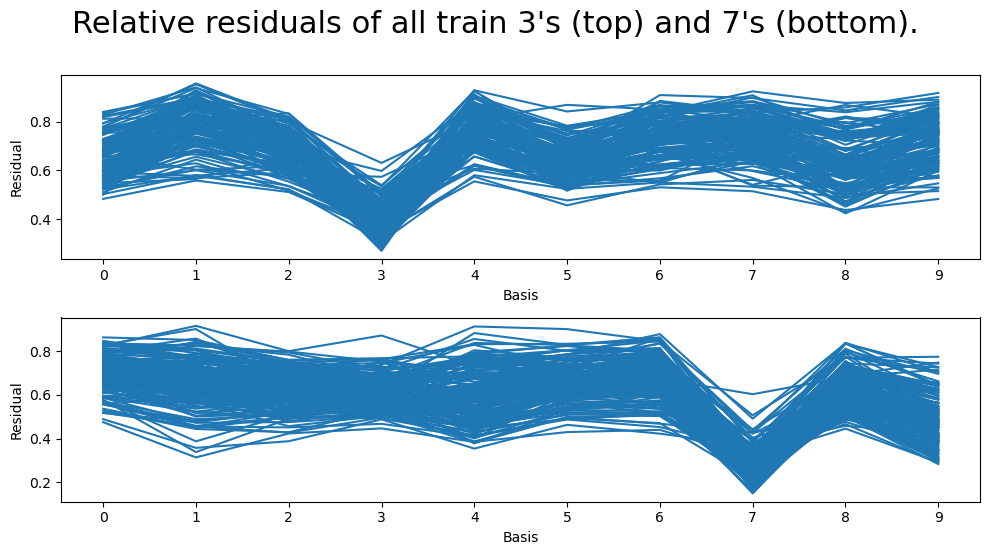

In [61]:
fig, ax = plt.subplots(2, 1, figsize=(10,5))

# Iterate through axes
for triaxes, dig in dict(zip(ax.reshape(-1), [3,7])).items():
    I = np.eye(256)

    # fiterate train set based on digit
    for col in train.loc[:, train.loc[0]==dig][1:].iteritems():
        
        # calculate and append the residual
        res = calc_resid(col[1], 10)

        # plot all residual for the specific digit    
        triaxes.plot(res, color='C0')
        triaxes.set_ylabel('Residual')
        triaxes.set_xlabel('Basis')
        triaxes.set_xticks(range(0,10))

fig.tight_layout()
fig.suptitle('Relative residuals of all train 3\'s (top) and 7\'s (bottom).', fontsize=22, y=1.1)
plt.show()

### Optimize number of Bases

* As mentioned previously, and explained in the corresponding Chapter of the book, the results in the classification of the test digit may vary depending on the selection of the k first singular vectors. In order to select the best value of k (between 5 and 20), we will calculate the accuracy achieved for the various values of k.

In [62]:
acc = []

# iterate through various values of k
for base in range(5, 21):
    print(f"Making predictions using {base:>2} singular vectors.", end=" ")
    sum = 0

    # all digits in the test set
    for col in test.iteritems():
        
        # save label and prediction
        label = int(col[1][0])
        pred = np.argmin(calc_resid(col[1][1:], base))
        
        if pred == label:
            sum += 1
    
    print(f"Accuracy: {sum/test.shape[1]*100:.2f}%")

    # append to acc list
    acc.append(sum/test.shape[1])

print(f"\nThe highest accuracy is achieved using {np.argmax(acc)+5} singular vectors.")

Making predictions using  5 singular vectors. Accuracy: 90.28%
Making predictions using  6 singular vectors. Accuracy: 90.53%
Making predictions using  7 singular vectors. Accuracy: 91.68%
Making predictions using  8 singular vectors. Accuracy: 92.03%
Making predictions using  9 singular vectors. Accuracy: 92.63%
Making predictions using 10 singular vectors. Accuracy: 93.17%
Making predictions using 11 singular vectors. Accuracy: 93.22%
Making predictions using 12 singular vectors. Accuracy: 93.57%
Making predictions using 13 singular vectors. Accuracy: 93.62%
Making predictions using 14 singular vectors. Accuracy: 93.92%
Making predictions using 15 singular vectors. Accuracy: 94.12%
Making predictions using 16 singular vectors. Accuracy: 93.87%
Making predictions using 17 singular vectors. Accuracy: 93.92%
Making predictions using 18 singular vectors. Accuracy: 94.17%
Making predictions using 19 singular vectors. Accuracy: 94.07%
Making predictions using 20 singular vectors. Accuracy:

### SPECIFIC TASK 1 

Tune the algorithm for accuracy of classification. Give a table or graph of the percentage of correctly classified digits as a function of the number of basis vectors.

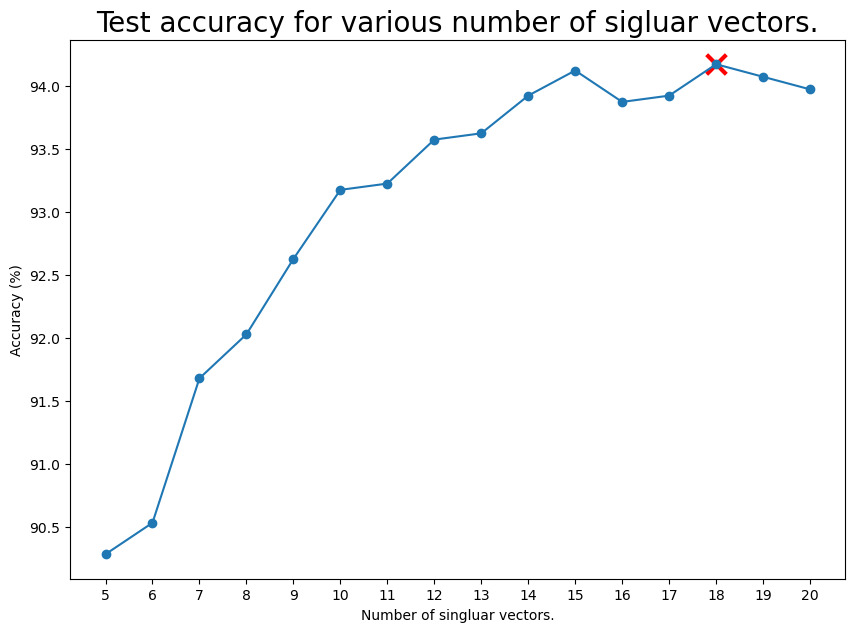

In [63]:
fig = plt.figure( figsize=(10,7))

plt.scatter(np.argmax(acc)+5, (np.array(acc)*100).max(),  marker='x', c='r', s=200, linewidths=3)
plt.plot(range(5,21), np.array(acc)*100,  marker='o')

plt.ylabel("Accuracy (%)")
plt.xlabel("Number of singluar vectors.")
plt.xticks(range(5,21))
plt.title('Test accuracy for various number of sigluar vectors.', fontsize=20, y=1)
plt.show()

### SPECIFIC TASK 2 

Check if all digits are equally easy or difficult to classify. Also look at some of the difficult ones, and see that in many cases they are very badly written.

* Using the optimal numer of singluar vectors (18), we will once again make predictions a create a confusion matrix, to see how each digit is classified and identify possible patterns in missclassification.

In [64]:
base = np.argmax(acc)+5
pred = []

print(f"Making predictions using {base:>2} singular vectors.")

# all digits in the test set
for col in test.iteritems():
    # save prediction
    pred.append(np.argmin(calc_resid(col[1][1:], base)))

pred = np.array(pred)
labels = test.iloc[0,:].values

Making predictions using 18 singular vectors.


In [65]:
print(classification_report(labels, pred))

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96       359
         1.0       0.97      0.98      0.98       264
         2.0       0.96      0.90      0.93       198
         3.0       0.91      0.90      0.91       166
         4.0       0.91      0.93      0.92       200
         5.0       0.93      0.88      0.91       160
         6.0       0.99      0.96      0.97       170
         7.0       0.95      0.96      0.95       147
         8.0       0.94      0.92      0.93       166
         9.0       0.91      0.93      0.92       177

    accuracy                           0.94      2007
   macro avg       0.94      0.94      0.94      2007
weighted avg       0.94      0.94      0.94      2007



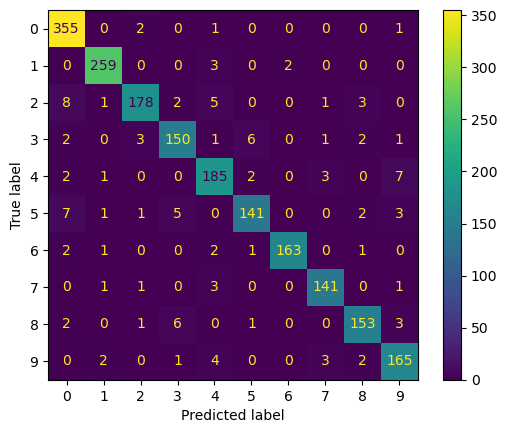

In [66]:
cm_train = confusion_matrix(labels, pred)
disp = ConfusionMatrixDisplay(cm_train)
disp.plot()

_ = plt.show()


As shown from the confusion matrix, as well as the accuracy score previously calculated, the algorithm performs quite well but there is room for improvement.

We can see that some digits, like zero and 1 are quite easy to classify, while some others, like 3 and 5 underperform. This is to be expected, since some digits, if written badly, can be confused, even by humans.
In more detail, we see that 3 is aften confused for a 5, and vice-versa, while 2 and 8 are often confused for a zero.

* We will randomnly chose some missclassified digits to see if they are indeed badly written

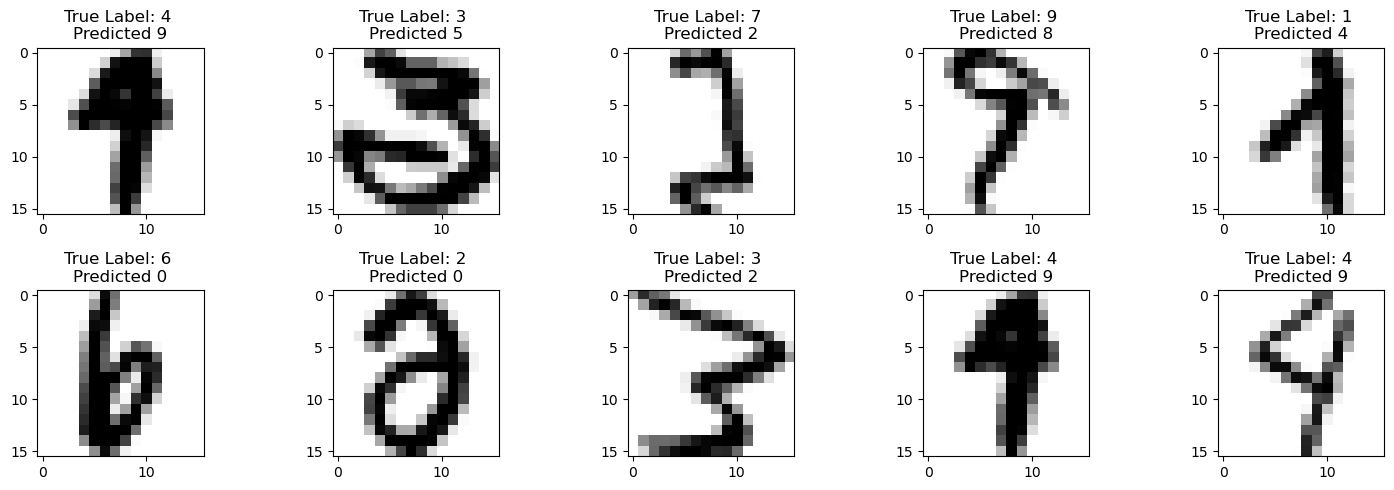

In [67]:
# create iterator
np.random.seed(42)
it = iter(np.random.choice(np.where(test.iloc[0,:].values != pred)[0], 10))

fig, ax = plt.subplots(2, 5, figsize=(15,5))

for i, triaxes in enumerate(ax.reshape(-1)):
    dig = next(it)
    triaxes.imshow(NormalizeImage(test.iloc[:,dig], True))
    triaxes.set_title(f'True Label: {int(test[dig][0])} \nPredicted {int(pred[dig])}')
fig.tight_layout()
plt.show()


As we can see even a human could make mistakes in some of the above examples, as they are badly written.

### SPECIFIC TASK 3

Check the singular values of the different classes. Is it motivated to use different numbers of basis vectors for different classes? If so, perform a few experiments to find out if it really pays off to use fewer basis vectors in one or two of the classes.

* For each class we will find the number of basis vectors that maximize the accuracy and save this number in the `best` list.

In [68]:
best = []

for dig in range(10):
    acc_opt = []
    print("Running for digit:", dig)
    # iterate through various values of k
    for base in range(5, 21):
        print(f"Making predictions using {base:>2} singular vectors.", end=" ")
        sum = 0

        # all digits in the test set
        for col in test.loc[:, test.loc[0]==dig].iteritems():
            
            # save label and prediction
            label = int(col[1][0])
            pred = np.argmin(calc_resid(col[1][1:], base))
            
            if pred == label:
                sum += 1
        
        print(f"Accuracy: {sum/test.loc[:, test.loc[0]==dig].shape[1]*100:.2f}%")

        # append to acc list
        acc_opt.append(sum/test.loc[:, test.loc[0]==dig].shape[1])

    print(f"\nThe highest accuracy is achieved using {np.argmax(acc_opt)+5} singular vectors.")
    print("\n\n\n")
    best.append(np.argmax(acc_opt)+5)
print(best)

Running for digit: 0
Making predictions using  5 singular vectors. Accuracy: 97.77%
Making predictions using  6 singular vectors. Accuracy: 97.21%
Making predictions using  7 singular vectors. Accuracy: 97.77%
Making predictions using  8 singular vectors. Accuracy: 97.77%
Making predictions using  9 singular vectors. Accuracy: 98.61%
Making predictions using 10 singular vectors. Accuracy: 98.33%
Making predictions using 11 singular vectors. Accuracy: 98.61%
Making predictions using 12 singular vectors. Accuracy: 98.61%
Making predictions using 13 singular vectors. Accuracy: 98.61%
Making predictions using 14 singular vectors. Accuracy: 98.89%
Making predictions using 15 singular vectors. Accuracy: 98.89%
Making predictions using 16 singular vectors. Accuracy: 98.89%
Making predictions using 17 singular vectors. Accuracy: 98.89%
Making predictions using 18 singular vectors. Accuracy: 98.89%
Making predictions using 19 singular vectors. Accuracy: 98.89%
Making predictions using 20 singul

* We will slightly modify the `calc_resid` function to get the k bases using the previously calculated ones.

In [69]:
def calc_resid_opt(digit, bases):
    """
    Function that calculates and returns the relative residual norm of all bases, given a specific digit.
    The function also takes a list containing the optimal number of bases as argument
    Input: pd.Series, itn
    Output: int
    """
    res = []
    # for each base, calculate and append the residual
    for i in range(10):
        u_k = u[i][:,0:bases[i]]
        r = np.linalg.norm( (I-(u_k.dot(u_k.T))).dot(digit) ) / np.linalg.norm(digit)
        res.append(r)
    return res

In [70]:
pred_opt = []

# all digits in the test set
for col in test.iteritems():

    # save prediction
    pred_opt.append(np.argmin(calc_resid_opt(col[1][1:], best)))

pred_opt = np.array(pred_opt)

In [71]:
print(classification_report(labels, pred_opt))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       359
         1.0       0.98      0.97      0.98       264
         2.0       0.99      0.68      0.80       198
         3.0       0.79      0.92      0.85       166
         4.0       0.90      0.94      0.92       200
         5.0       0.89      0.90      0.90       160
         6.0       0.89      0.99      0.94       170
         7.0       0.89      0.96      0.92       147
         8.0       0.88      0.90      0.89       166
         9.0       0.99      0.88      0.93       177

    accuracy                           0.92      2007
   macro avg       0.92      0.91      0.91      2007
weighted avg       0.92      0.92      0.92      2007



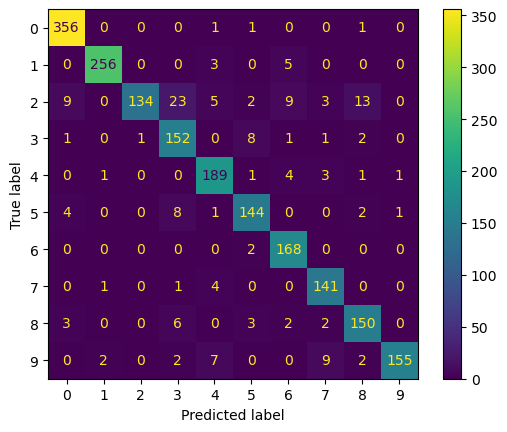

In [72]:
cm_train = confusion_matrix(labels, pred_opt)
disp = ConfusionMatrixDisplay(cm_train)
disp.plot()

_ = plt.show()


* We may observe that while some predictions were improved (like digits 3 and 5), others got worse (like digit 2). 

**We experimented with various bases but we were not able to improve the results.**

* Finally we will plot the Singular values of each digit.

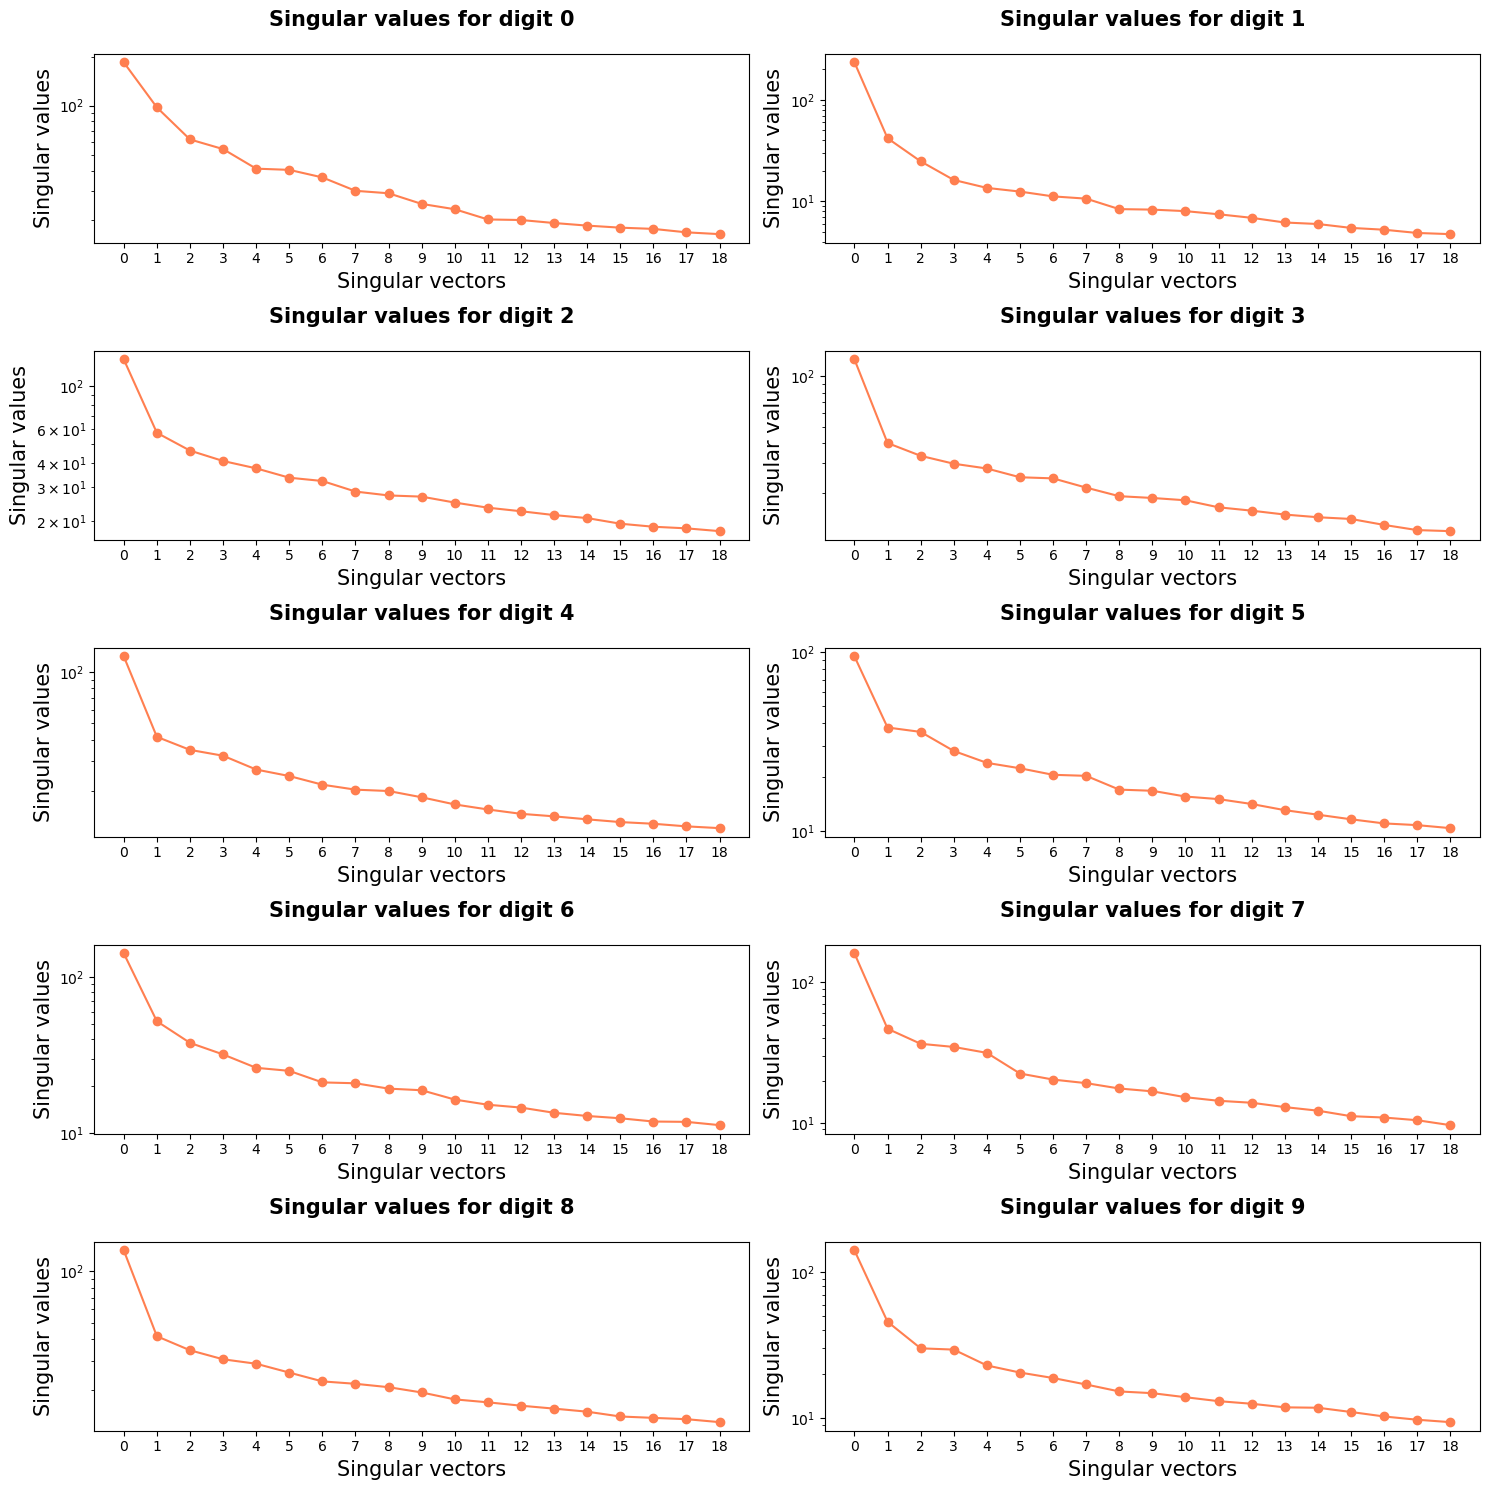

In [73]:
fig, ax = plt.subplots(5, 2, figsize=(15,15))

for i, triaxes in enumerate(ax.reshape(-1)):
    triaxes.plot(s[i][:19], color='coral', marker='o')
    triaxes.set_title(f'Singular values for digit {i}',fontsize=15,weight='bold',pad=20)
    triaxes.set_ylabel('Singular values' ,fontsize=15)
    triaxes.set_xlabel('Singular vectors' ,fontsize=15)
    triaxes.set_yscale('log')
    triaxes.set_xticks(range(0,19))

fig.tight_layout()
plt.show()

# OPTIONAL TASKS

## TWO-STAGE ALGORITHM WITH SVD

In order to save operations in the test phase, implement a two-stage algorithm: In the first stage compare the unknown digit only to the first singular vector in each class. If for one class the residual is significantly smaller than for the others, classify as that class. Otherwise perform the algorithm above. Is it possible to get as good results for this variant? How frequently is the second stage unnecessary?

* In order to chose a good threshold to determine the "significant" value of the residual, which need to be smaller than the others, we will plot the relative residuals of each digit for each of the 10 bases, using all train digits.

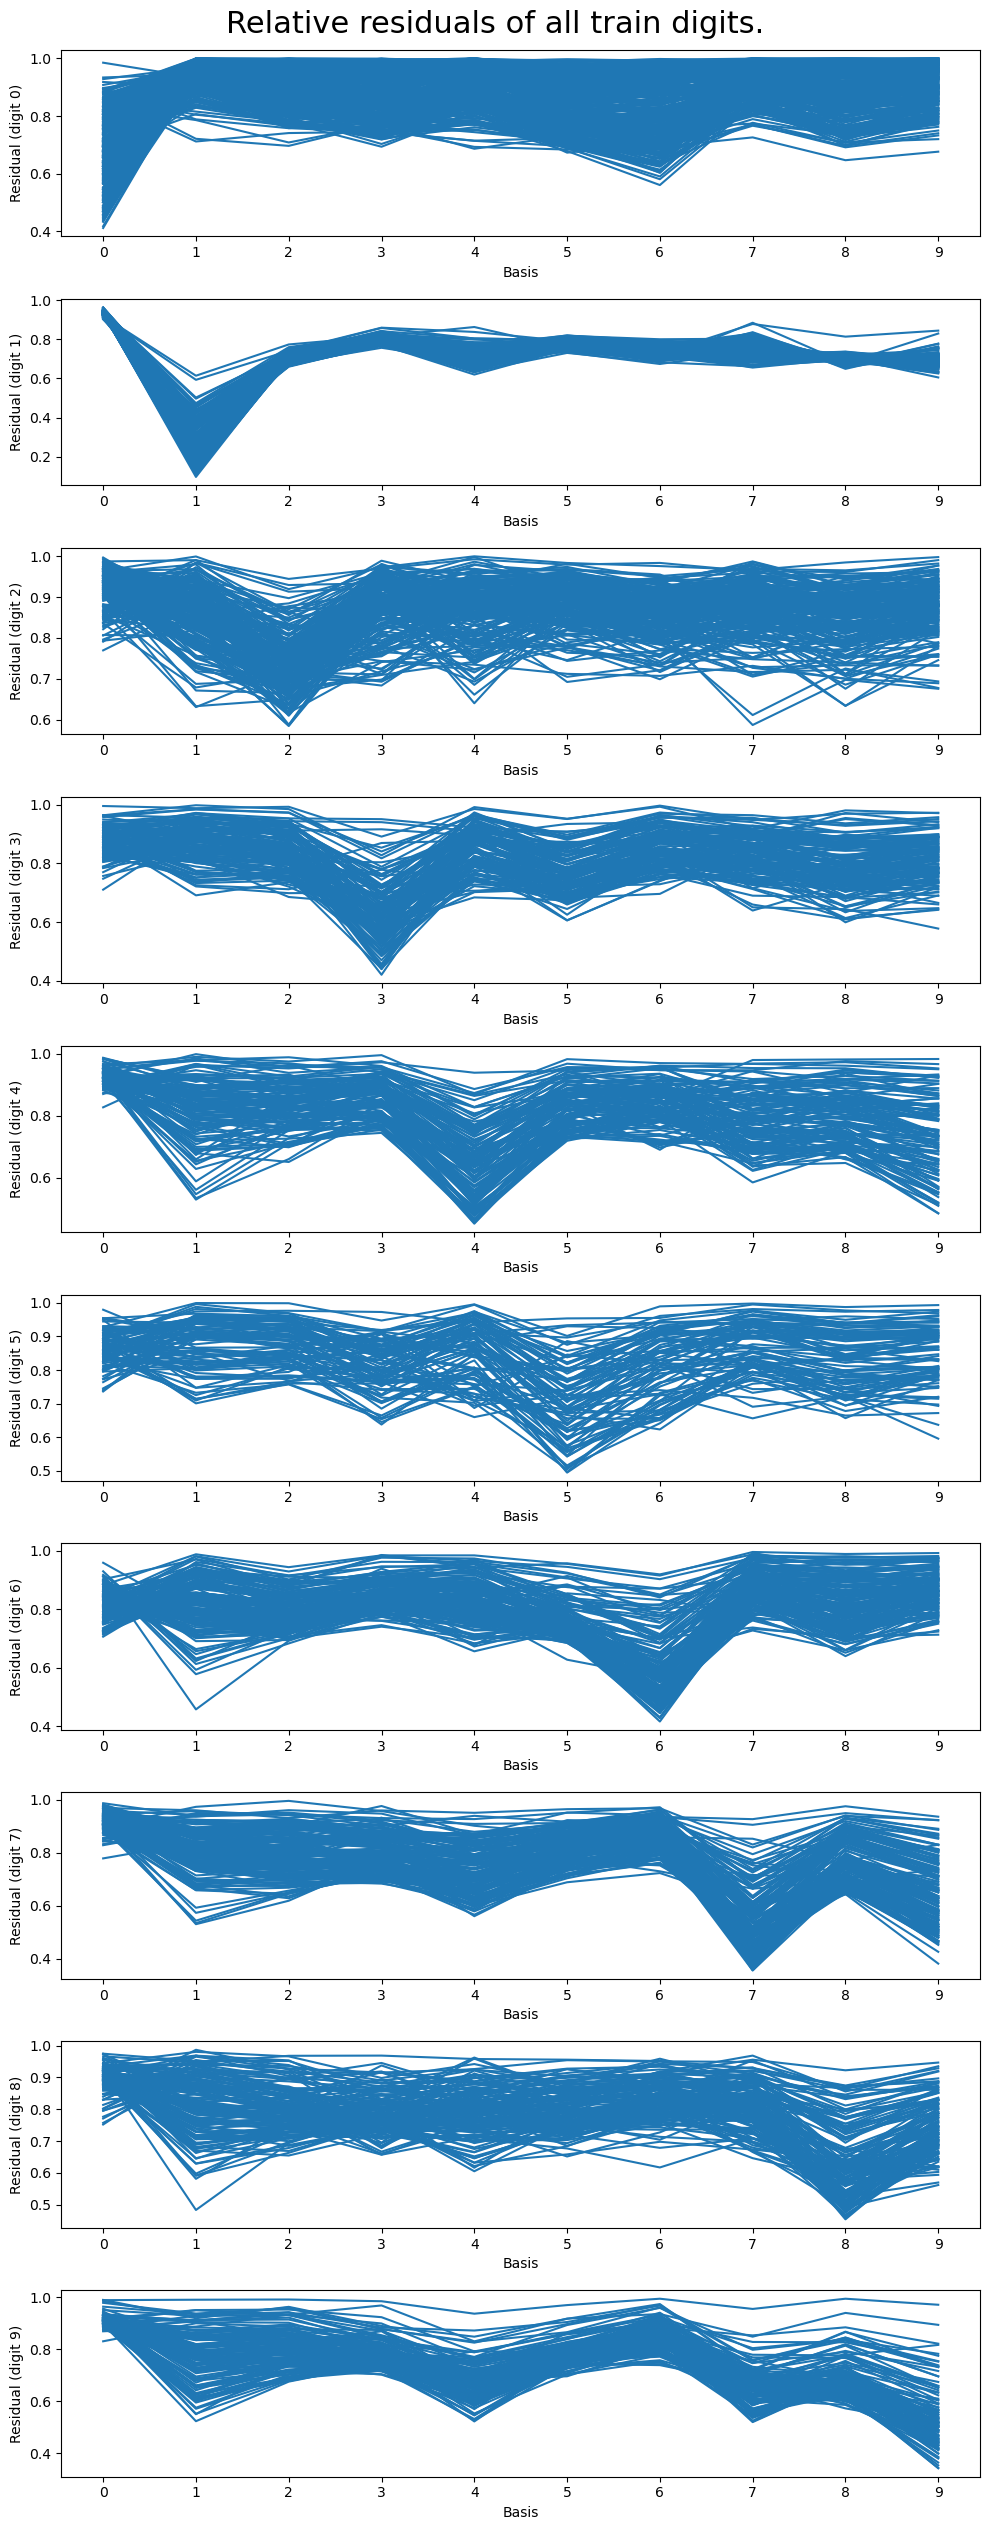

In [74]:
fig, ax = plt.subplots(10, 1, figsize=(10,25))

# Iterate through axes
for triaxes, dig in dict(zip(ax.reshape(-1), range(10))).items():
    I = np.eye(256)

    # fiterate train set based on digit
    for col in train.loc[:, train.loc[0]==dig][1:].iteritems():
        
        # calculate and append the residual
        res = calc_resid(col[1], 1)

        # plot all residual for the specific digit    
        triaxes.plot(res, color='C0')
        triaxes.set_ylabel(f'Residual (digit {dig})')
        triaxes.set_xlabel('Basis')
        triaxes.set_xticks(range(0,10))

fig.tight_layout()
fig.suptitle('Relative residuals of all train digits.', fontsize=22, y=1.01)
plt.show()

* Based on the above, we will set a threshold of 0.1. if the smaller residual is at least 0.1 smaller than the second, we will classify the number as that class, else we will use the other technique.

In [75]:
base = np.argmax(acc)+5
pred, freq = [], 0

print(f"Making predictions using {base:>2} singular vectors.")

# all digits in the test set
for col in test.iteritems():
    
    a = calc_resid(col[1][1:], 1)
    if np.amin(np.array(a)[a != np.amin(a)]) - np.amin(a) > 0.1:
        pred.append(np.argmin(a))
        freq += 1
    else:
        # save prediction
        pred.append(np.argmin(calc_resid(col[1][1:], base)))

pred = np.array(pred)
labels = test.iloc[0,:].values

print(f"The predictions were made using one singular vector {freq} times (out of {test.shape[1]}).")

Making predictions using 18 singular vectors.
The predictions were made using one singular vector 1030 times (out of 2007).


In [76]:
print(classification_report(labels, pred))

              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96       359
         1.0       0.97      0.98      0.98       264
         2.0       0.96      0.89      0.92       198
         3.0       0.91      0.90      0.91       166
         4.0       0.90      0.92      0.91       200
         5.0       0.93      0.88      0.90       160
         6.0       0.98      0.96      0.97       170
         7.0       0.95      0.96      0.95       147
         8.0       0.94      0.92      0.93       166
         9.0       0.91      0.93      0.92       177

    accuracy                           0.94      2007
   macro avg       0.94      0.93      0.93      2007
weighted avg       0.94      0.94      0.94      2007



* As we can see the the results achieved through this method are quite close to the original results, with the selected threshold. Moreover the second stage was nessecary only half of the times. This indicates that if performance and speed are a highest priority, this method can be used.